## Applying the bias scan tool on a BERT disinformation classifier
In this notebook, the bias scan tool is applied on a BERT-based disinformation classifier. The bias scan tool is based on an implementation of the k-means Hierarchical Bias Aware Clustering (HBAC) method\*. The python script `./helper_functions.py` contains functions that execute the bias scan. A conceptual description how the bias scan works, including the rationale why k-means is chosen as a clustering algorithm and paramater choices, can be found in the [bias scan tool report](https://github.com/NGO-Algorithm-Audit/Bias_scan/blob/master/Bias_scan_tool_report.pdf).

The classifier is used to make predictions on the Twitter15\*\* data set. Details on pre-processing steps performed on this dataset are provided in the `../data/Twitter_dataset/Twitter_preprocessing.ipynb` notebook. Details on training the BERT disinformation classifier is provided in the `../case_studies/BERT_disinformation_classifier/BERT_Twitter_classifier.ipynb` notebook.

This notebook is structured as follows:
1. Load data and pre-processing
2. Bias scan using k-means clustering
3. Clustering results
4. Statistical testing of inter-cluster difference 

\* Misztal-Radecka, Indurkya, *Information Processing and Management*. Bias-Aware Hierarchical Clustering for detecting the discriminated groups of users in recommendation systems (2021).

\*\* Liu, Xiaomo and Nourbakhsh, Armineh and Li, Quanzhi and Fang, Rui and Shah, Sameena, *Proceedings of the 24th ACM International on Conference on Information and Knowledge Management* (2015) [[link to dataset]](https://www.dropbox.com/s/7ewzdrbelpmrnxu/rumdetect2017.zip?dl=0&file_subpath=%2Frumor_detection_acl2017)

### Load libraries

In [1]:
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

# IPython
from IPython.display import Markdown, display

# matplotlib
import matplotlib.pyplot as plt

# helper functions
from helper_functions import *

# welch's t-test
import scipy.stats as stats

warnings.filterwarnings('ignore')

### 1. Load data and pre-processing

In [2]:
# read data
path = '../case_studies/BERT_disinformation_classifier/pred_BERT.csv'
df_pred = pd.read_csv(path)

# change column names
df_pred.columns = ['text','predicted_class','true_class']

# Calculating absolute errors
df_pred['errors'] = abs(df_pred['predicted_class'] - df_pred['true_class'])
df_pred.head()

,text,predicted_class,true_class,errors
0,marlboro man dies of smoking-related disease U...,0,1,1
1,#oklahoma prosecutor files formal notification...,0,0,0
2,#mexico: doubts grow over the fate of 43 missi...,0,0,0
3,who killed deandre joshua - and why? still mor...,1,0,1
4,i feel some type of way. URL,1,1,0


#### Add features to data

In [3]:
path_feat = '../data/Twitter_dataset/twitter_full.csv'
df_feat = pd.read_csv(path_feat)
df_feat.head(2)

,#followers,user_engagement,verified,depth,user_id1,tweet_id1,user_id2,length,#hashs,#mentions,#URLs,sentiment_score,text,label
0,15375121,72.567469,1,0.0,ROOT,489800427152879616,2467791,95,0,0,2,-0.3182,malaysia airlines says it lost contact with pl...,1
1,3673898,55.294333,1,0.0,ROOT,560474897013415936,59553554,118,0,1,1,0.8398,for just $1 you can get a free jr. frosty with...,1


#### Data cleaning

In [4]:
df_full = pd.merge(df_pred, df_feat, on=['text'])

# remove certain columns
df_full = df_full.drop(columns=['depth', 'user_id1', 'user_id2','label'])

# features
features = df_full.drop(['text','predicted_class', 'true_class', 'errors'], axis=1)
features.head()

df_full.head()

,text,predicted_class,true_class,errors,#followers,user_engagement,verified,tweet_id1,length,#hashs,#mentions,#URLs,sentiment_score
0,marlboro man dies of smoking-related disease U...,0,1,1,2881966,48.857582,1,427846006600777729,52,0,0,2,0.0000
1,#oklahoma prosecutor files formal notification...,0,0,0,2432446,4.103050,1,517850508380618752,124,3,0,0,-0.8442
2,#mexico: doubts grow over the fate of 43 missi...,0,0,0,4144151,9.042582,1,520630231531802624,102,1,0,2,-0.7184
3,who killed deandre joshua - and why? still mor...,1,0,1,606870,6.919301,1,539833716852273152,117,0,0,1,-0.8720
4,i feel some type of way. URL,1,1,0,2528852,11.271492,1,524320261667950592,28,0,0,1,0.0000


#### Data initialization

In [5]:
full_data = init_dataset(df_full,features)
full_data.head()

,predicted_class,true_class,errors,#followers,user_engagement,verified,tweet_id1,length,#hashs,#mentions,#URLs,sentiment_score,clusters,new_clusters
0,0,1,1,-0.249684,-0.063442,0.498224,-1.230690,-1.607344,-0.513855,-0.325831,0.921514,0.423952,0,-1
1,0,0,0,-0.299704,-0.901957,0.498224,0.305262,1.519500,4.912457,-0.325831,-2.054385,-1.463204,0,-1
2,0,0,0,-0.109236,-0.809411,0.498224,0.352699,0.564075,1.294915,-0.325831,0.921514,-1.181986,0,-1
3,1,0,1,-0.502843,-0.849192,0.498224,0.680412,1.215501,-0.513855,-0.325831,-0.566435,-1.525350,0,-1
4,1,1,0,-0.288977,-0.767650,0.498224,0.415671,-2.649625,-0.513855,-0.325831,-0.566435,0.423952,0,-1


In [6]:
full_data = full_data.drop(['errors','clusters','new_clusters'],axis=1)

In [7]:
full_data.head()

,predicted_class,true_class,#followers,user_engagement,verified,tweet_id1,length,#hashs,#mentions,#URLs,sentiment_score
0,0,1,-0.249684,-0.063442,0.498224,-1.230690,-1.607344,-0.513855,-0.325831,0.921514,0.423952
1,0,0,-0.299704,-0.901957,0.498224,0.305262,1.519500,4.912457,-0.325831,-2.054385,-1.463204
2,0,0,-0.109236,-0.809411,0.498224,0.352699,0.564075,1.294915,-0.325831,0.921514,-1.181986
3,1,0,-0.502843,-0.849192,0.498224,0.680412,1.215501,-0.513855,-0.325831,-0.566435,-1.525350
4,1,1,-0.288977,-0.767650,0.498224,0.415671,-2.649625,-0.513855,-0.325831,-0.566435,0.423952


### 2. HBAC using k-means clustering

Clustering algorithms parameters:

In [31]:
clustering_paramaters = {
    "n_clusters": 2,
    "init": "k-means++",
    "n_init": 20,
    "max_iter": 300,
    "random_state": 10,
}

Specify:
- Minimal splittable cluster size
- Minimal acceptable cluster size

In [32]:
# minimal splittable cluster size
split_cluster_size = round(0.05 * len(full_data))
print("minimal splittable cluster size: ", split_cluster_size)

# minimal acceptable cluster size
acc_cluster_size = round(0.03 * len(full_data))
print("minimal splitacceptabletable cluster size: ", acc_cluster_size)

minimal splittable cluster size:  9
minimal splitacceptabletable cluster size:  5


Performing bias scan using helper functions.

In [8]:
iterations_max = 20
x = 0 # initial cluster number
initial_bias = 0
variance_list = []
average_accuracy = accuracy(full_data)
minimal_splittable_cluster_size = round(0.05 * len(full_data))
minimal_acceptable_cluster_size = round(0.03 * len(full_data))
print("average_accuracy is: ", average_accuracy) 

for i in range(1, iterations_max):
    if i != 1:
        
        # calculate variance for cluster
        variance_list.append(calculate_variance(full_data)) 
        
    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # k-means clustering 
    kmeans_algo = KMeans(**clustering_paramaters).fit(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1))
    
    candidate_cluster['new_clusters'] = pd.DataFrame(kmeans_algo.predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)),index=candidate_cluster.index) 
    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])

    # with get_max_abs_bias, but now it only finds the discriminated clusters
    max_abs_bias = get_max_negative_bias(full_data) 
    min_new_size = get_min_cluster_size(full_data)
    
    if (max_abs_bias <= initial_bias) & (min_new_size > minimal_acceptable_cluster_size):
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
        
        x = get_next_cluster(full_data)
        initial_bias = max_abs_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('done')

average_accuracy is:  0.8352272727272727
done


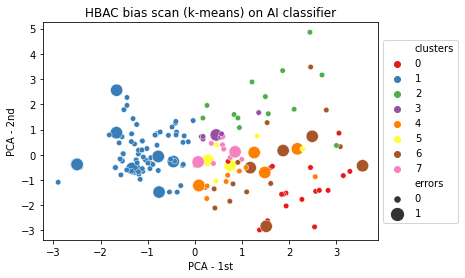

In [9]:
pca_plot(full_data)

### 3. Analysing clustering results

Identifying cluster with most negative bias.

In [10]:
c = get_max_bias_cluster(full_data)
max_bias = round(bias_acc(full_data, c, "clusters"), 2)
highest_biased_cluster = full_data[full_data['clusters']==c]
print(f"cluster {c} has the highest negative bias: " + str(max_bias))
print("#elements in highest biased cluster:", len(highest_biased_cluster))

1 has bias 0.026397515527950333
2 has bias 0.17791411042944782
3 has bias 0.02282333051563812
6 has bias -0.14317425083240842
5 has bias -0.1259509721048182
7 has bias -0.03734939759036138
4 has bias -0.27032520325203246
0 has bias 0.18354430379746833
cluster 4 has the highest negative bias: -0.27
#elements in highest biased cluster: 12


Accuracy of classifier on full dataset and on cluster with highest discrimination bias.

In [11]:
accuracy_full_data = accuracy(full_data)
most_biased_cluster_kmeans_aware = bias_acc(full_data, c, 'clusters')
full_data[full_data['clusters']==c]

print('General accuracy of classifier on this dataset:', accuracy_full_data)

General accuracy of classifier on this dataset: 0.8352272727272727


Select and print discriminated cluser.

In [12]:
discriminated_cluster = full_data[full_data['clusters']==c]
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
discriminated_cluster

Number of instances in discriminated cluster: 12
Number of errors in discriminated clusters:  5


,predicted_class,true_class,errors,#followers,user_engagement,verified,tweet_id1,length,#hashs,#mentions,#URLs,sentiment_score,clusters,new_clusters
20,0,0,0,0.818782,-0.504531,0.498224,-3.993434,1.693213,-0.513855,-0.325831,-2.054385,0.423952,4,-1.0
39,1,0,1,-0.547101,-0.967053,0.498224,-2.589796,1.085216,-0.513855,1.968022,-0.566435,0.423952,4,-1.0
53,1,1,0,-0.328480,-0.097789,0.498224,-1.581861,0.433790,-0.513855,-0.325831,-0.566435,0.423952,4,-1.0
80,0,0,0,-0.526359,-0.033811,0.498224,-1.583059,0.216648,-0.513855,-0.325831,-0.566435,0.821636,4,-1.0
82,0,0,0,-0.228727,0.585315,0.498224,-2.294693,-0.955918,-0.513855,-0.325831,-0.566435,0.423952,4,-1.0
89,1,1,0,-0.479167,-0.038694,0.498224,-1.581945,1.302358,-0.513855,-0.325831,-0.566435,1.277442,4,-1.0
125,0,1,1,-0.568767,-0.936721,0.498224,-1.927772,1.258930,-0.513855,-0.325831,-0.566435,1.110455,4,-1.0
139,0,1,1,0.254462,0.052834,0.498224,-1.229347,-0.651919,-0.513855,-0.325831,-0.566435,1.184001,4,-1.0
140,0,1,1,0.247318,0.046874,0.498224,-1.232112,-0.651919,-0.513855,-0.325831,-0.566435,1.184001,4,-1.0
153,0,0,0,0.739568,0.084540,0.498224,-2.044804,-0.565063,-0.513855,-0.325831,-0.566435,0.761727,4,-1.0


### 4. Statistical testing of inter-cluster difference 

Compute difference between cluster with most negative bias and rest of dataset.

In [15]:
not_discriminated = full_data[full_data['clusters']!=c]
difference = (discriminated_cluster.mean()) - (not_discriminated.mean()) 
diff_dict = difference.to_dict()
difference

predicted_class   -0.136179
true_class         0.089431
errors             0.270325
#followers        -0.075613
user_engagement   -0.146339
verified           0.534679
tweet_id1         -2.141401
length             0.387854
#hashs            -0.227935
#mentions         -0.144531
#URLs             -0.740951
sentiment_score    0.956865
clusters           1.890244
new_clusters      -0.079268
dtype: float64

Unscaling the data. Print summary of cluster with most negative bias and the rest of data.

In [16]:
# unscaling the discriminated cluster
unscaled_discriminated = full_data.loc[discriminated_cluster.index, :]

# unscaled other data
unscaled_remaining = full_data.drop(discriminated_cluster.index)

display(unscaled_remaining.describe())
display(unscaled_discriminated.describe())

print(discriminated_cluster.index)

,predicted_class,true_class,errors,#followers,user_engagement,verified,tweet_id1,length,#hashs,#mentions,#URLs,sentiment_score,clusters,new_clusters
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000
mean,0.469512,0.493902,0.146341,0.005155,0.009978,-0.036455,0.146005,-0.026445,0.015541,0.009854,0.050519,-0.065241,2.109756,-0.920732
std,0.500598,0.501494,0.354531,1.031143,1.030314,1.029632,0.852055,1.005391,1.021145,1.024076,1.014713,0.998341,2.150794,0.332028
min,0.000000,0.000000,0.000000,-0.570363,-0.978823,-2.007130,-2.528993,-2.779910,-0.513855,-0.325831,-2.054385,-1.652099,0.000000,-1.000000
25%,0.000000,0.000000,0.000000,-0.560557,-0.819699,0.498224,0.092301,-0.489063,-0.513855,-0.325831,-0.566435,-0.943465,1.000000,-1.000000
50%,0.000000,0.000000,0.000000,-0.373021,-0.124573,0.498224,0.426232,0.129792,-0.513855,-0.325831,0.921514,0.423952,1.000000,-1.000000
75%,1.000000,1.000000,0.000000,0.044536,0.334254,0.498224,0.610057,0.520647,-0.513855,-0.325831,0.921514,0.423952,2.250000,-1.000000
max,1.000000,1.000000,1.000000,5.772971,3.181331,0.498224,1.264540,2.214354,4.912457,6.555729,0.921514,2.426233,7.000000,1.000000


,predicted_class,true_class,errors,#followers,user_engagement,verified,tweet_id1,length,#hashs,#mentions,#URLs,sentiment_score,clusters,new_clusters
count,12.000000,12.000000,12.000000,12.000000,12.000000,1.200000e+01,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.0,12.0
mean,0.333333,0.583333,0.416667,-0.070457,-0.136361,4.982238e-01,-1.995396,0.361410,-0.212394,-0.134677,-0.690431,0.891624,4.0,-1.0
std,0.492366,0.514929,0.514929,0.488551,0.498018,1.159590e-16,0.761999,0.932048,0.704063,0.662178,0.429534,0.547926,0.0,0.0
min,0.000000,0.000000,0.000000,-0.568767,-0.967053,4.982238e-01,-3.993434,-0.955918,-0.513855,-0.325831,-2.054385,0.423952,4.0,-1.0
25%,0.000000,0.000000,0.000000,-0.490965,-0.437245,4.982238e-01,-2.296571,-0.586777,-0.513855,-0.325831,-0.566435,0.423952,4.0,-1.0
50%,0.000000,1.000000,0.000000,-0.228493,-0.036253,4.982238e-01,-1.755749,0.325219,-0.513855,-0.325831,-0.566435,0.791681,4.0,-1.0
75%,1.000000,1.000000,1.000000,0.249104,0.060761,4.982238e-01,-1.581924,1.226358,-0.513855,-0.325831,-0.566435,1.184001,4.0,-1.0
max,1.000000,1.000000,1.000000,0.818782,0.587521,4.982238e-01,-1.229347,1.693213,1.294915,1.968022,-0.566435,2.240469,4.0,-1.0


Int64Index([20, 39, 53, 80, 82, 89, 125, 139, 140, 153, 160, 161], dtype='int64')


In [17]:
unscaled_discriminated

,predicted_class,true_class,errors,#followers,user_engagement,verified,tweet_id1,length,#hashs,#mentions,#URLs,sentiment_score,clusters,new_clusters
20,0,0,0,0.818782,-0.504531,0.498224,-3.993434,1.693213,-0.513855,-0.325831,-2.054385,0.423952,4,-1.0
39,1,0,1,-0.547101,-0.967053,0.498224,-2.589796,1.085216,-0.513855,1.968022,-0.566435,0.423952,4,-1.0
53,1,1,0,-0.328480,-0.097789,0.498224,-1.581861,0.433790,-0.513855,-0.325831,-0.566435,0.423952,4,-1.0
80,0,0,0,-0.526359,-0.033811,0.498224,-1.583059,0.216648,-0.513855,-0.325831,-0.566435,0.821636,4,-1.0
82,0,0,0,-0.228727,0.585315,0.498224,-2.294693,-0.955918,-0.513855,-0.325831,-0.566435,0.423952,4,-1.0
89,1,1,0,-0.479167,-0.038694,0.498224,-1.581945,1.302358,-0.513855,-0.325831,-0.566435,1.277442,4,-1.0
125,0,1,1,-0.568767,-0.936721,0.498224,-1.927772,1.258930,-0.513855,-0.325831,-0.566435,1.110455,4,-1.0
139,0,1,1,0.254462,0.052834,0.498224,-1.229347,-0.651919,-0.513855,-0.325831,-0.566435,1.184001,4,-1.0
140,0,1,1,0.247318,0.046874,0.498224,-1.232112,-0.651919,-0.513855,-0.325831,-0.566435,1.184001,4,-1.0
153,0,0,0,0.739568,0.084540,0.498224,-2.044804,-0.565063,-0.513855,-0.325831,-0.566435,0.761727,4,-1.0


####  Test to check statistical significance of inter-cluster difference (per feature)
Applying a Welch’s two-samples t-test for unequal variances to examine whether the differences in means for each feature are statistically significant and store results in a dictionary.

In [18]:
welch_dict = {}

features = [col for col in full_data.columns.tolist() if col not in ['tweet_id1','scaled_errors','predicted_class','true_class','errors','clusters','new_clusters']]
    
for i in features:
    welch_i = stats.ttest_ind(unscaled_discriminated[i], unscaled_remaining[i], equal_var=False)
    
    # attach to dictionary
    welch_dict[i] = welch_i.pvalue
    
welch_dict

{'#followers': 0.6467397356252811,
 'user_engagement': 0.385596186280206,
 'verified': 4.2134591548386974e-10,
 'length': 0.18980909194823187,
 '#hashs': 0.31343620423302876,
 '#mentions': 0.49603837513052973,
 '#URLs': 5.109093947722555e-05,
 'sentiment_score': 4.6065802323426135e-05}

#### p-values
A small p-value (p < 0.05) indicates that it is unlikely to observe inter-cluster difference due to chance. Sort difference on statistical significance (p-value).

In [19]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
cluster_analysis_df = pd.DataFrame([diff_dict, welch_dict]).T
cluster_analysis_df.columns = ['difference','p-value']
cluster_analysis_df = cluster_analysis_df.sort_values('p-value')
cluster_analysis_df

,difference,p-value
verified,0.53468,0.00000
sentiment_score,0.95686,0.00005
#URLs,-0.74095,0.00005
length,0.38785,0.18981
#hashs,-0.22793,0.31344
user_engagement,-0.14634,0.38560
#mentions,-0.14453,0.49604
#followers,-0.07561,0.64674
predicted_class,-0.13618,NaN
true_class,0.08943,NaN


#### Conclusion
Suspected negative bias by the classifier on the basis of:
- verified profile;
- sentiment score (based on the [VADER](https://github.com/cjhutto/vaderSentiment) library);
- #URLs.

This means that Twitter users with a verified profile, above average [sentiment score](https://github.com/cjhutto/vaderSentiment#about-the-scoring) and below average number of URLs in their tweets are classified significantly more often as disinformation by the BERT-based classifier. 

#### What's next?
Qualitative assessment with the help of subject matter experts to verify the measured quantitaive disparities. Additionally, sensitivity testing would be beneficial to shed light into the robustness of the bias scan tool. 